In [1]:
import dataset_utils
import os
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from config import cfg
from datasets import LandCoverDataset
from models.deeplab import get_model as get_deeplab_model
from PIL import Image
from torch.utils.data import DataLoader, Subset
from utils import get_validation_augmentation, get_training_augmentation, get_preprocessing, save_history, save_model, reverse_one_hot, colour_code_segmentation, visualize

In [2]:
LANDCOVER_ROOT = '/root/deepglobe'
cfg.merge_from_file('cfg/deeplab_resnet50_advance_aug.yaml')

In [3]:
train_df, val_df = dataset_utils.get_landcover_train_val_df(LANDCOVER_ROOT, random_state=cfg.SEED)
dataset_info = dataset_utils.get_landcover_info(LANDCOVER_ROOT, include_unknow=False)
class_names = dataset_info['class_names']
class_rgb_values = dataset_info['class_rgb_values']
select_class_rgb_values = dataset_info['select_class_rgb_values']

In [4]:
num_classes = len(select_class_rgb_values)
model, preprocessing_fn = get_deeplab_model(num_classes, cfg.MODEL.encoder)

In [5]:
device = torch.device('cpu')
# witoon model loading
# weight_path = '/root/rtml/project/weights/deeplabv3_resnet50_advance_aug/best_model.pth'
# model.load_state_dict(torch.load(weight_path, map_location=device))
# model.eval()

# max model loading
model = torch.load('best_model_max.pth', map_location=device)

In [6]:
valid_dataset = LandCoverDataset(
    train_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset_vis = LandCoverDataset(
    train_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

In [7]:
# select from index, unreliable
# rand_idx = 89
# image_np, mask_np = valid_dataset[rand_idx]
# image_vis, _ = valid_dataset_vis[rand_idx]
# image_vis = image_vis.astype('uint8')

In [8]:
image_path, mask_path = '/root/deepglobe/train/6399_sat.jpg', '/root/deepglobe/train/6399_mask.png'
image_np, mask_np = valid_dataset.get_from_paths(image_path, mask_path)
image_vis, _ = valid_dataset_vis.get_from_paths(image_path, mask_path)
image_vis = image_vis.astype('uint8')

In [9]:
X = torch.from_numpy(image_np)

In [10]:
yhat_mask = model(X.unsqueeze(0))

In [11]:
pred_mask_encoded = yhat_mask.squeeze().detach().numpy()

In [12]:
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask_encoded.transpose(1, 2, 0)), select_class_rgb_values)

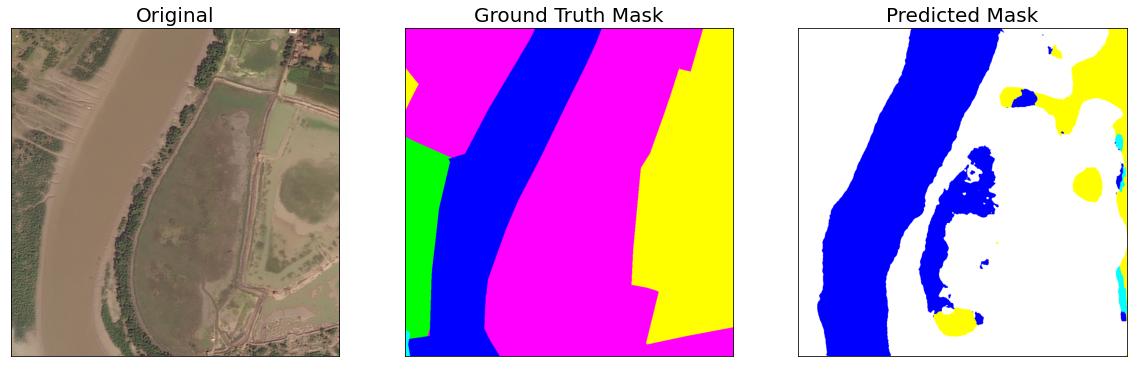

In [13]:
visualize(original=image_vis, ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask_np.transpose(1, 2, 0)), select_class_rgb_values), predicted_mask=pred_mask)